In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from univariate_analysis import get_hist, get_box

from env import username, password, hostname

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17,
            propertylandusedesc
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid);
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df

In [3]:
properties = get_zillow_data()

Using cache


In [4]:
properties.shape

(2152864, 17)

In [5]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152853.0,3.287195,0.954757,0.0,3.00,3.0,4.0,25.0
bathroomcnt,2152853.0,2.230687,0.999281,0.0,2.00,2.0,3.0,32.0
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.0,1257.00,1623.0,2208.0,952576.0
taxvaluedollarcnt,2152371.0,461896.052361,699675.940049,1.0,188170.00,327671.0,534527.0,98428909.0
yearbuilt,2143526.0,1960.949681,22.162196,1801.0,1949.00,1958.0,1976.0,2016.0
fips,2152864.0,6048.377330,20.433289,6037.0,6037.00,6037.0,6059.0,6111.0
numberofstories,590839.0,1.386009,0.537773,1.0,1.00,1.0,2.0,41.0
basementsqft,1538.0,651.190507,552.078809,20.0,261.75,519.5,889.5,8516.0
fireplacecnt,287596.0,1.178726,0.474376,1.0,1.00,1.0,1.0,9.0
roomcnt,2152847.0,1.864986,3.122051,0.0,0.00,0.0,5.0,96.0


Looks like there are some weird numbers in here.

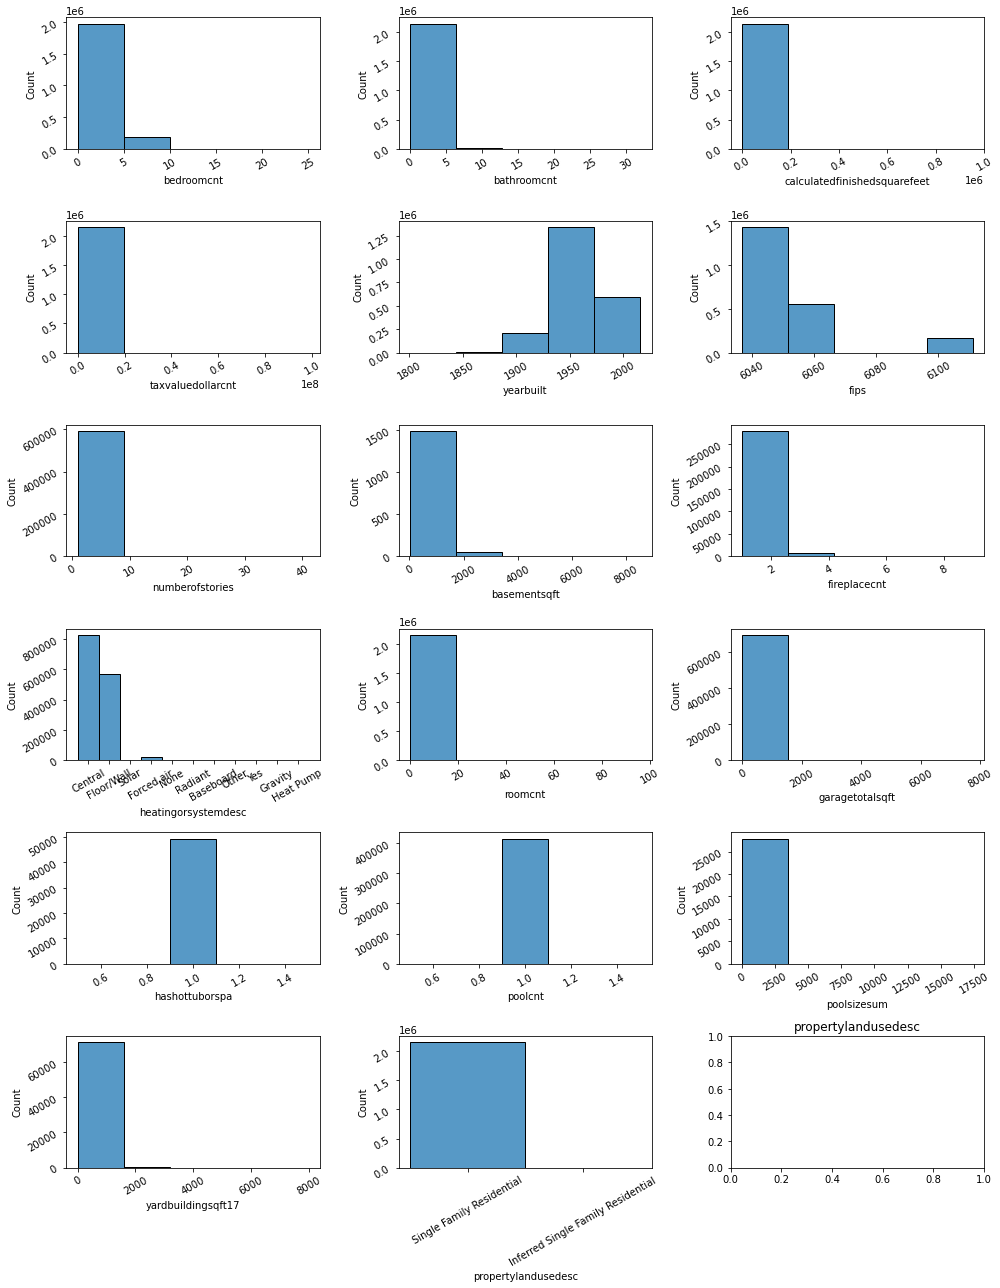

In [6]:
get_hist(properties, properties.columns)

TypeError: Horizontal orientation requires numeric `x` variable.

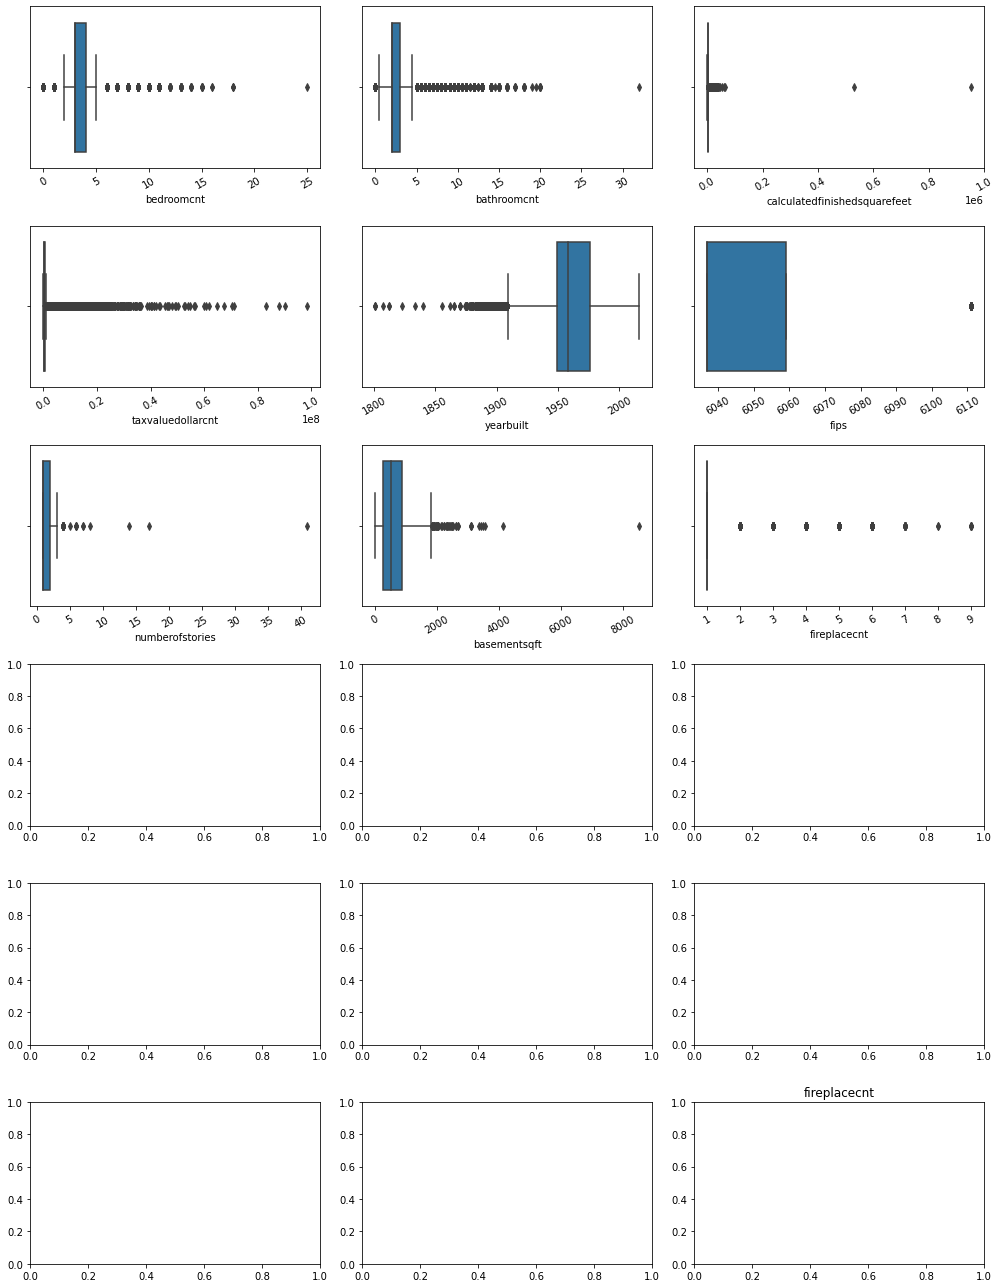

In [7]:
get_box(properties, properties.columns)

In [ ]:
properties.info(show_counts = True)

fireplacecnt unique values: Null, 1, 2, 3, 4, 5, 6, 7, 8, 9
numberofstories unique values: Null, 1, 2, 3, 4, 5, 6, 7, 8, 14, 17, 41
basementsqft range: 20 - 8516 with Nulls
roomcnt is mostly non null
garagetotalsqft has 698633 non null values, some of the nulls may be no garage
hashottuborspa unique values: Null, 1
poolcnt unique values: Null, 1
poolsizesum ^
yardbuildingsqft range: 10 - 7983 with Nulls

In [ ]:
properties.isnull().sum()

In [ ]:
# We have several columns with missing values. Let's see the proportions of these missing values per columns.
properties.isnull().mean()

In [ ]:
# The missing values make up only a small percentage of the whole in each column. Let's how many rows have missing values.
(properties.isnull().sum(axis = 1) != 0).sum(), (properties.isnull().sum(axis = 1) != 0).mean()

Roughly half a percent of the rows comprises of missing values. Let's try to get a little more insight here.

In [ ]:
# How many rows have 2 or more missing values?
(properties.isnull().sum(axis = 1) >= 2).sum(), (properties.isnull().sum(axis = 1) >= 2).mean()

In [ ]:
# What's our distribution of missing values when we look at rows with 1 missing value or less?
rows_with_one_or_less_missing_values = properties.isnull().sum(axis = 1) < 2
properties[rows_with_one_or_less_missing_values].isnull().sum()

We will need square footage for the first iteration of our model so we will remove all rows missing that value as well as any rows missing more than one value. We'll also remove rows missing taxvaluedollarcnt since this is our target variable. We will impute everything else.

In [ ]:
# Remove rows with two or more missing values.
properties = properties[rows_with_one_or_less_missing_values]

# Remove rows missing square footage
rows_not_missing_square_feet = properties.calculatedfinishedsquarefeet.notnull()
properties = properties[rows_not_missing_square_feet]

# Remove rows missing taxvaluedollarcnt
rows_not_missing_taxvalue = properties.taxvaluedollarcnt.notnull()
properties = properties[rows_not_missing_taxvalue]

In [ ]:
properties.isnull().sum()

In [ ]:
# We'll fill in yearbuilt with the mode.
properties.yearbuilt.mode()[0]

In [ ]:
properties.yearbuilt.fillna(properties.yearbuilt.mode()[0], inplace = True)

# Let's also cast the column to int.
properties.yearbuilt = properties.yearbuilt.astype('int')

In [ ]:
properties.isnull().sum()

In [ ]:
properties.info()

In [ ]:
# Finally let's fill in taxamount with the mean.
properties.taxamount.mean()

In [ ]:
properties.taxamount.fillna(properties.taxamount.mean(), inplace = True)

In [ ]:
properties.isnull().sum()

In [ ]:
properties.shape

In [ ]:
# There was also some weird values in the square footage column where the value was 1. Let's take a look.

properties.calculatedfinishedsquarefeet.value_counts().sort_index().head(30)

Based on some quick research, some of the smallest homes in the world appear to be around 70 square feet. In case some of these entries are legitimate we'll keep everything at 60 square feet or more.

In [ ]:
sixty_square_feet_or_more = properties.calculatedfinishedsquarefeet >= 60
properties = properties[sixty_square_feet_or_more]

In [ ]:
properties.describe().T

In [ ]:
# Let's see the tax values
properties.taxvaluedollarcnt.value_counts().sort_index().head(30)

We won't do anything more.

In [ ]:
# One last thing let's rename these columns

properties = properties.rename(columns = {
    'bedroomcnt' : 'bedroom_count',
    'bathroomcnt' : 'bathroom_count',
    'calculatedfinishedsquarefeet' : 'square_feet',
    'taxvaluedollarcnt' : 'tax_value_dollar_count',
    'yearbuilt' : 'year_built',
    'taxamount' : 'tax_amount',
    'fips' : 'fed_code',
    'propertylandusedesc' : 'property_land_use_description'
})
properties.info()

In [ ]:
properties.describe().T

All done!

# 3

Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [ ]:
# These are the acquisition functions

def get_zillow_data(use_cache: bool = True) -> pd.core.frame.DataFrame:
    '''
        Return a dataframe containing data from the zillow properties dataset.

        If a zillow.csv file containing the data does not already
        exist the data will be cached in that file inside the current
        working directory. Otherwise, the data will be read from the
        .csv file.

        Parameters
        ----------
        use_cache: bool, default True
            If True the dataset will be retrieved from a csv file if one
            exists, otherwise, it will be retrieved from the MySQL database. 
            If False the dataset will be retrieved from the MySQL database
            even if the csv file exists.

        Returns
        -------
        DataFrame: A Pandas DataFrame containing the data from the zillow
            dataset is returned.
    '''

    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        df = pd.read_sql(_get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df
    
def _get_zillow_sql() -> str:
    '''
        Returns the SQL code required to retrieve the zillow dataset
        from the MySQL database.
    '''

    return '''
        SELECT
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            taxamount,
            fips,
            propertylandusedesc
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND propertylandusetype.propertylandusedesc = 'Single Family Residential';
    '''

In [ ]:
# This is the prepare function

def prepare_zillow_data(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
        Returns a prepared zillow dataset with all missing values handled.
        
        Parameters
        ----------
        df: DataFrame
            A pandas dataframe containing the unprepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    # Remove rows with two or more missing values.
    rows_with_one_or_less_missing_values = df.isnull().sum(axis = 1) < 2
    df = df[rows_with_one_or_less_missing_values]

    # Remove rows missing square footage
    rows_not_missing_square_feet = df.calculatedfinishedsquarefeet.notnull()
    df = df[rows_not_missing_square_feet]

    # Remove rows missing taxvaluedollarcnt
    rows_not_missing_taxvalue = df.taxvaluedollarcnt.notnull()
    df = df[rows_not_missing_taxvalue]
    
    # Fill in yearbuilt column with the mode and cast to int
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.yearbuilt = df.yearbuilt.astype('int')
    
    # Fill in the taxamount column with the mean
    df.taxamount.fillna(df.taxamount.mean(), inplace = True)
    
    # Remove properties with less than 60 square feet
    sixty_square_feet_or_more = df.calculatedfinishedsquarefeet >= 60
    df = df[sixty_square_feet_or_more]

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'tax_value_dollar_count',
        'yearbuilt' : 'year_built',
        'taxamount' : 'tax_amount',
        'fips' : 'fed_code',
        'propertylandusedesc' : 'property_land_use_description'
    })
    
    return df

In [ ]:
# Now let's bring it all together

def wrangle_zillow() -> pd.core.frame.DataFrame:
    '''
        Returns the acquired and prepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    return prepare_zillow_data(get_zillow_data())

In [ ]:
# Let's test it
df = wrangle_zillow()

In [ ]:
df.info(show_counts = True)